# Generar N frames sintéticos + "labels"

### Imports

In [3]:
import os
import json
import csv
import pandas as pd
import numpy as np
import mmcv
import keras
import tensorflow as tf
import cv2
from NDStandardScaler import NDStandardScaler
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from tensorflow import keras
from tensorflow.keras import layers

### Paso 1
Procesar los N (14660) frames sintéticos de Blender con un modelo de pose detection ya entrenado 

In [6]:
%run demo/topdown_demo_with_mmdet \
    demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py \
    https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth \
    configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py \
    https://download.openmmlab.com/mmpose/v1/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth \
    --input inputs/1630-16300.mp4 --save-predictions \
    --output-root outputs/Blender/ 

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 14660/14660, 2.0 task/s, elapsed: 7379s, ETA:     0s

C:\Users\crv\miniconda3\envs\openmmlab\lib\site-packages\json_tricks\encoders.py:394: UserWarning: json-tricks: numpy scalar serialization is experimental and may work differently in future versions
  warnings.warn('json-tricks: numpy scalar serialization is experimental and may work differently in future versions')


predictions have been saved at outputs/Blender//results_1630-16300.json


### Paso 2
Entrenar un modelo de aprendizaje supervisado para predecir la posición (x, y) del "heap" del jugador proyectado en la pista a partir de los keypoints de la jugador.

In [22]:
# Obtener los frames 
video = mmcv.VideoReader('outputs/Blender/1630-16300.mp4')
video.cvt2frames('outdir')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 14660/14660, 46.8 task/s, elapsed: 313s, ETA:     0s


In [8]:
# Cargar los datos de los keypoints
data = json.load(open('outputs/Blender/results_1630-16300.json'))

# Hay algunos fotogramas de los cuales no ha predecido los keypoints, por lo que hay que guardarse la posición
zeros = []

X = []
for i in range(0, len(data['instance_info'])):
    if len(data['instance_info'][i]['instances']) > 0:
        # guardarse solo la posición de las keypoints
        X.append(data['instance_info'][i]['instances'][0]['keypoints'])
    else:
        zeros.append(i)

# fotogramas que no se han podido predecir keypoints
zeros.sort(reverse = True)

y = list()

# Cargar las posiciones de la ground truth
with open('outputs/Blender/labels-1630-16300.csv','r') as fp: # open the csv file for reading (will close when "with" block ends)
    for line in fp.readlines(): # go over remaining lines
        col = line.strip().split(";") # get the columns of data
        new_item = [col[1],col[2]] # keep only 2nd and 3th items in a new list, starting count from 0, since this is how lists work in python
        y.append(new_item) # add the current item to the item list

# coger solo las 14660 primeros fotogramas
y = y[0:14660]


# eliminar los fotogramas de las cuales no hay keypoints predecidos
for i in zeros:
    y.pop(i)

### Sandardization of data ###
PredictorScaler = NDStandardScaler()
TargetVarScaler = NDStandardScaler()

# Storing the fit object for later reference
PredictorScalerFit = PredictorScaler.fit(X)
TargetVarScalerFit = TargetVarScaler.fit(y)

# Generating the standardized values of X and y
X = PredictorScalerFit.transform(X)
y = TargetVarScalerFit.transform(y)
 
# Split the data into training and testing set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

# create ANN model
model = Sequential()
    
model.add(tf.keras.layers.Flatten())
    
model.add(Dense(units=5, input_dim=17, kernel_initializer='GlorotNormal', activation='relu'))

model.add(Dense(2, kernel_initializer='GlorotNormal'))

model.compile(loss='MeanSquaredError', optimizer='adam')

model.fit(X_train, y_train ,batch_size = 2, epochs = 10, verbose=1)
 
Predictions = model.predict(X_test)

Predictions = TargetVarScalerFit.inverse_transform(Predictions)

y_test_orig = TargetVarScalerFit.inverse_transform(y_test)

Epoch 1/10
5855/5855 [==============================] - 4s 666us/step - loss: 0.0380
Epoch 2/10
5855/5855 [==============================] - 4s 694us/step - loss: 0.0078
Epoch 3/10
5855/5855 [==============================] - 4s 680us/step - loss: 0.0069
Epoch 4/10
5855/5855 [==============================] - 4s 699us/step - loss: 0.0064
Epoch 5/10
5855/5855 [==============================] - 4s 675us/step - loss: 0.0061
Epoch 6/10
5855/5855 [==============================] - 4s 704us/step - loss: 0.0059
Epoch 7/10
5855/5855 [==============================] - 4s 666us/step - loss: 0.0058
Epoch 8/10
5855/5855 [==============================] - 4s 680us/step - loss: 0.0057
Epoch 9/10
5855/5855 [==============================] - 4s 707us/step - loss: 0.0057
Epoch 10/10
92/92 [==============================] - 0s 586us/step


## Prueba con datos reales

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

05/11 11:59:25 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


/Users/jiabowang/miniconda3/envs/openmmlab/lib/python3.10/site-packages/json_tricks/encoders.py:394: UserWarning: json-tricks: numpy scalar serialization is experimental and may work differently in future versions
  warnings.warn('json-tricks: numpy scalar serialization is experimental and may work differently in future versions')


predictions have been saved at outputs/TopDown//results_Padel3.json


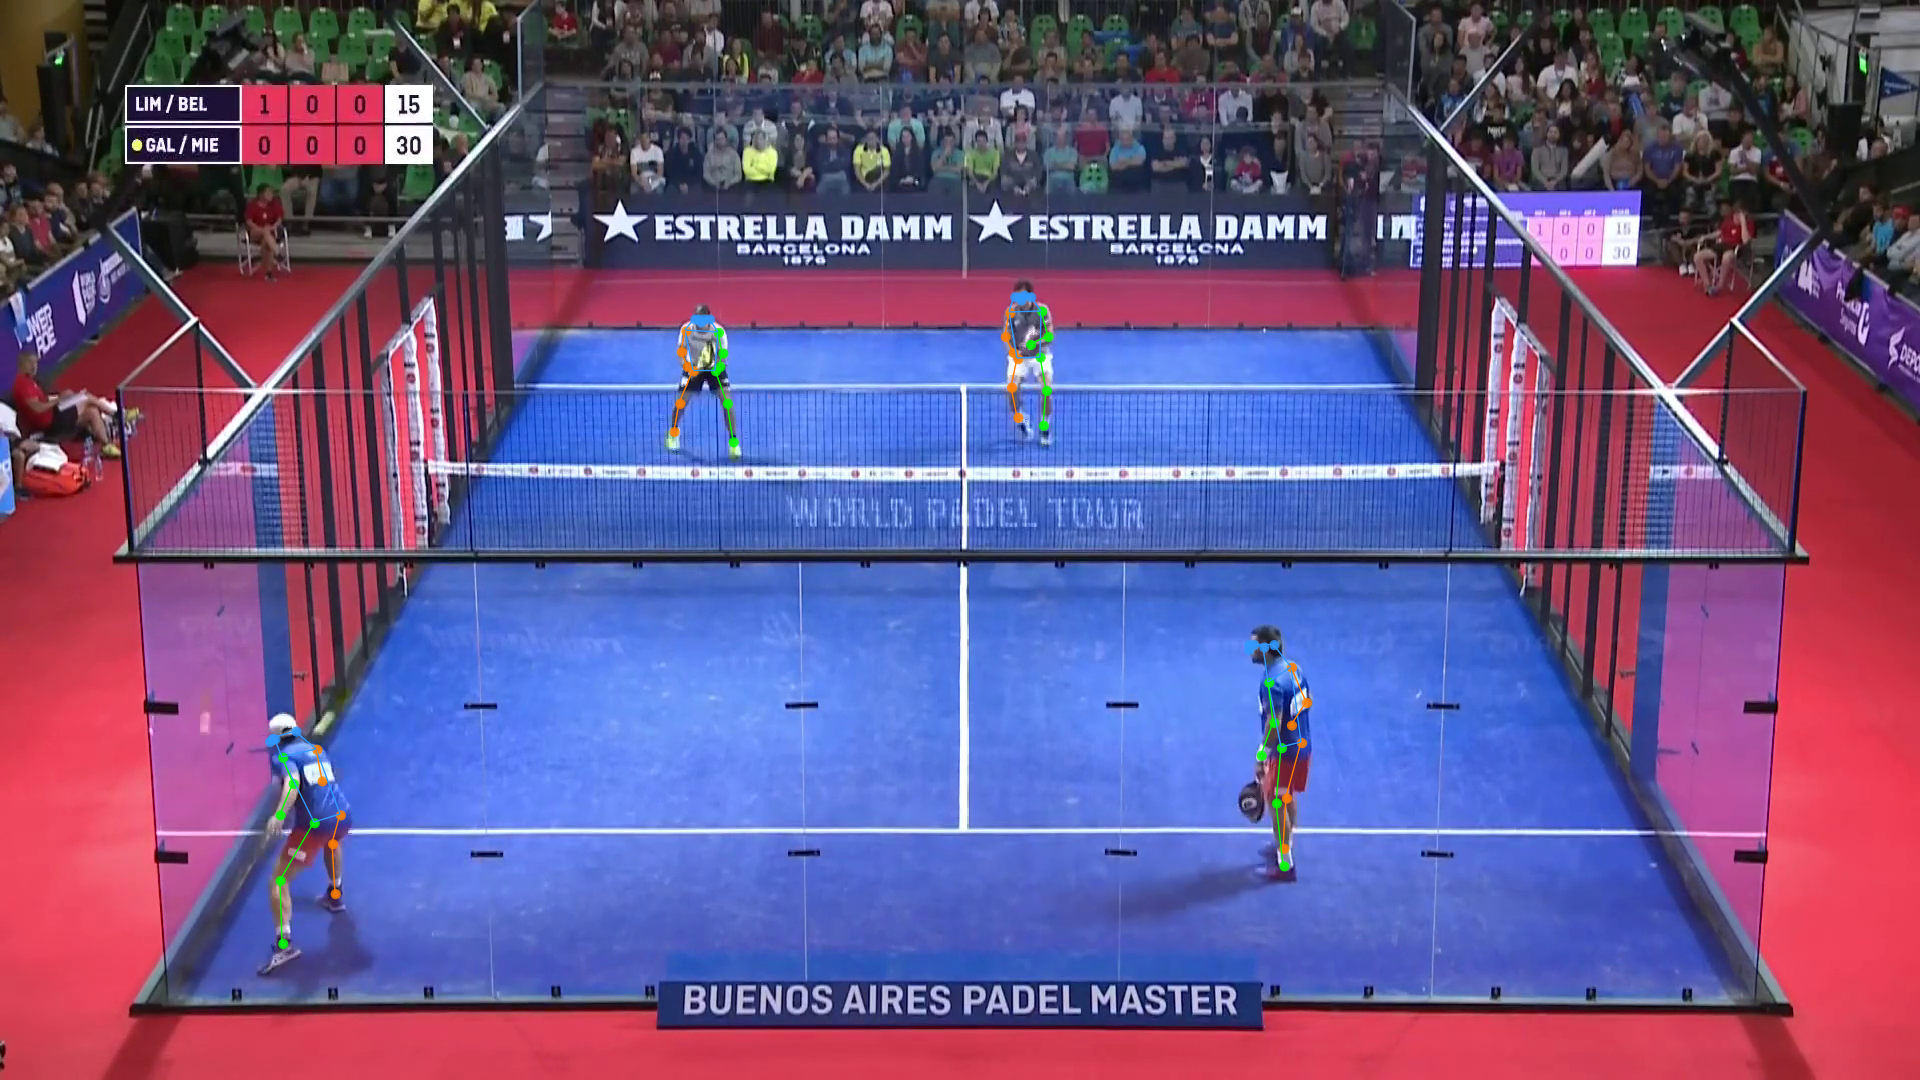

In [93]:
%run demo/topdown_demo_with_mmdet \
    demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py \
    https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth \
    configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py \
    https://download.openmmlab.com/mmpose/v1/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth \
    --input inputs/Padel3.png --save-predictions \
    --output-root outputs/TopDown/ --device cpu

Image.open("outputs/TopDown/Padel3.png")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 34)                0         
                                                                 
 dense_4 (Dense)             (None, 5)                 175       
                                                                 
 dense_5 (Dense)             (None, 2)                 12        
                                                                 
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 27ms/step
[[1384.3192   728.1772 ]
 [ 409.40836  811.2107 ]
 [1010.66016  364.21036]
 [ 729.7294   379.89584]]


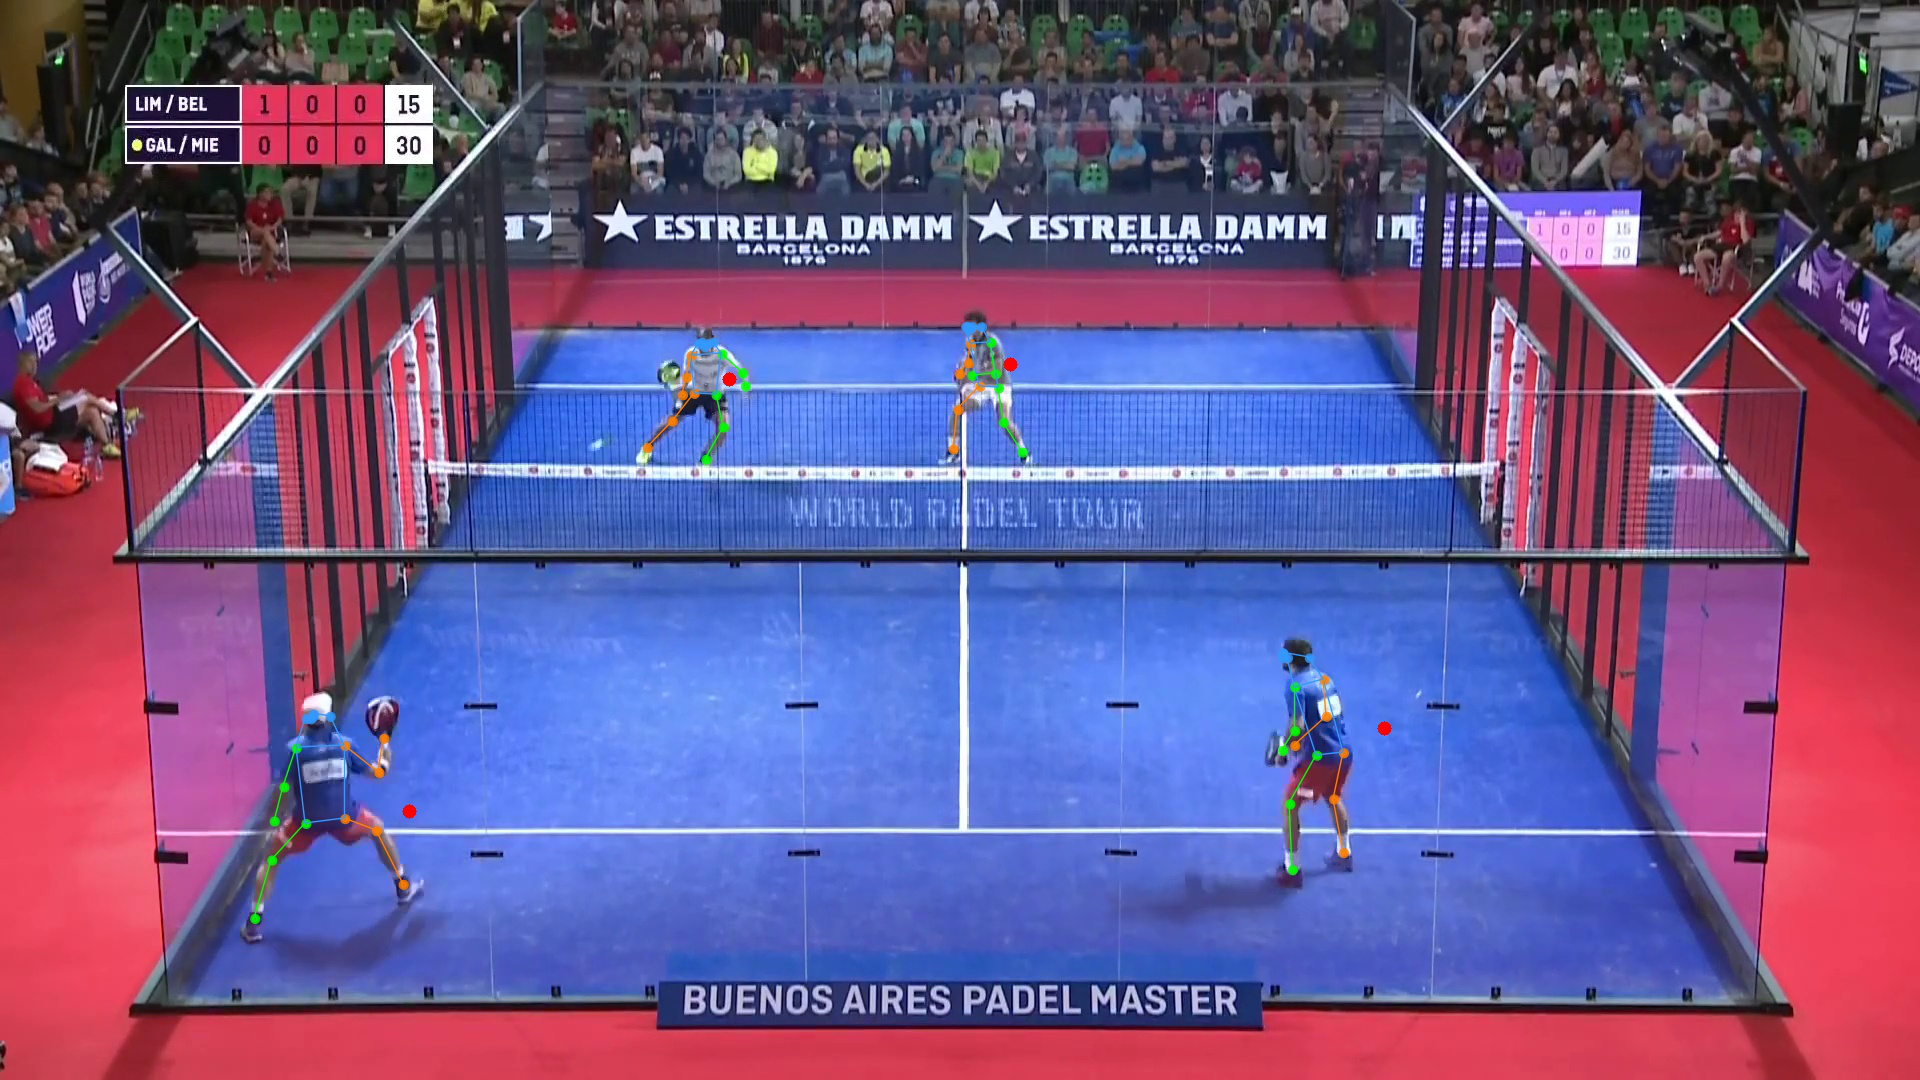

In [9]:
model.summary()
data = json.load(open('outputs/TopDown/results_Padel2.json'))
X = []
for i in range(0, len(data['instance_info'])):
    X.append(data['instance_info'][i]['keypoints'])
        
p=model.predict(X)
print(p)

image = cv2.imread("outputs/TopDown/Padel2.png")

i = cv2.circle(image, (int(p[0][0]),int(p[0][1])), radius=7, color=(0, 0, 255), thickness=-1)
i = cv2.circle(i, (int(p[1][0]),int(p[1][1])), radius=7, color=(0, 0, 255), thickness=-1)
i = cv2.circle(i, (int(p[2][0]),int(p[2][1])), radius=7, color=(0, 0, 255), thickness=-1)
i = cv2.circle(i, (int(p[3][0]),int(p[3][1])), radius=7, color=(0, 0, 255), thickness=-1)
filename = 'savedImage.jpg'
cv2.imwrite(filename, i)

Image.open("savedImage.jpg")

2/2 [==============================] - 0s 1ms/step


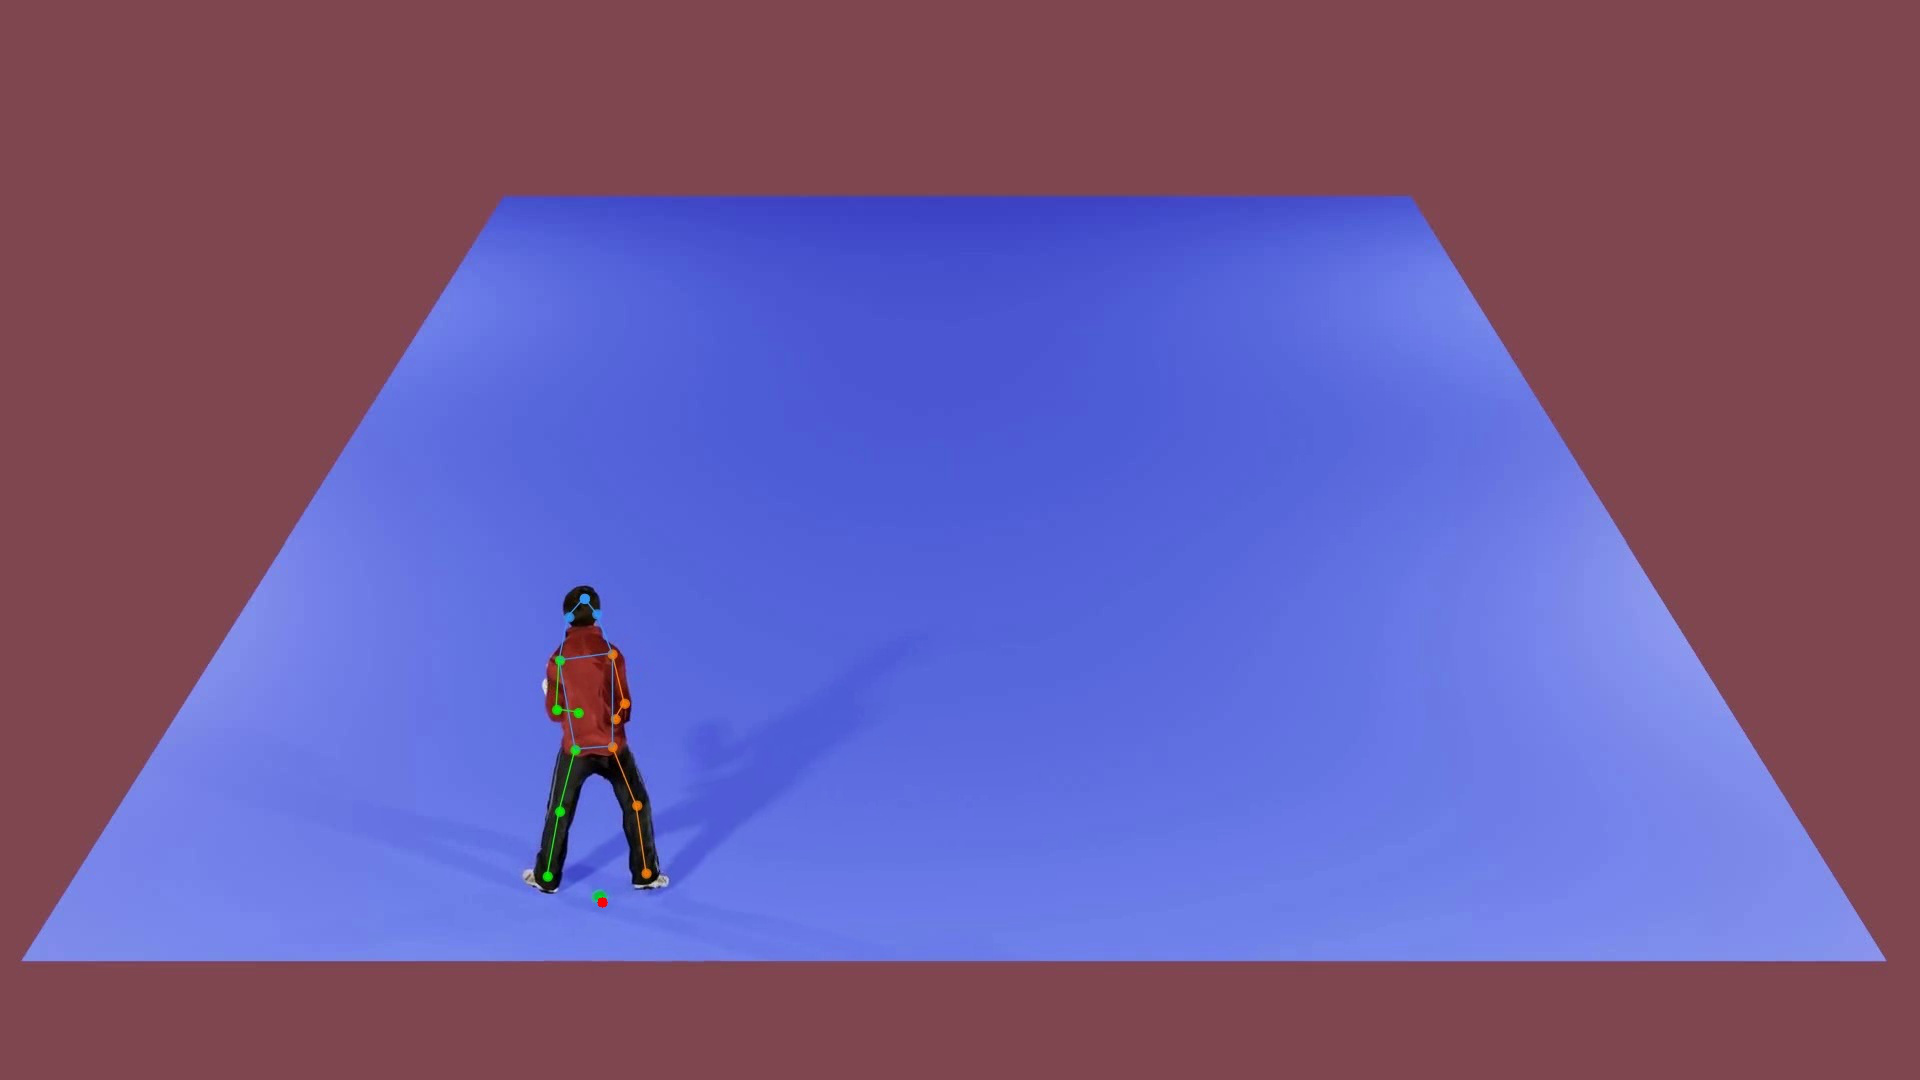

In [100]:
data = json.load(open('outputs/Blender/results_1630-16300.json'))
# print(data['instance_info'][0]['instances'][0]['keypoints'])
zeros = []
X = []
for i in range(0, len(data['instance_info'])):
    if len(data['instance_info'][i]['instances']) > 0:
        X.append(data['instance_info'][i]['instances'][0]['keypoints'])
    else:
        zeros.append(i)
        
zeros.sort(reverse = True)

X = X[14599:14660]

y = list()
with open('outputs/Blender/labels-1630-16300.csv','r') as fp: # open the csv file for reading (will close when "with" block ends)
    for line in fp.readlines(): # go over remaining lines
        col = line.strip().split(";") # get the columns of data
        new_item = [col[1],col[2]] # keep only 2nd and 3th items in a new list, starting count from 0, since this is how lists work in python
        y.append(new_item) # add the current item to the item list
y = y[0:14660]

y = y[14599:14660]


### Sandardization of data ###
PredictorScaler = NDStandardScaler()
TargetVarScaler = NDStandardScaler()

# Storing the fit object for later reference
PredictorScalerFit = PredictorScaler.fit(X)
TargetVarScalerFit = TargetVarScaler.fit(y)

# Generating the standardized values of X and y
X = PredictorScalerFit.transform(X)
y = TargetVarScalerFit.transform(y)


    
Predictions=model.predict(X)

Predictions=TargetVarScalerFit.inverse_transform(Predictions)

image = cv2.imread("inputs/3.jpg")

i = cv2.circle(image, (int(Predictions[0][0]), int(Predictions[0][1])), radius=5, color=(0, 0, 255), thickness=-1)
#i = cv2.circle(i, (int(Predictions[1][0]),int(Predictions[1][1])), radius=5, color=(0, 0, 255), thickness=-1)
#i = cv2.circle(i, (int(Predictions[2][0]),int(Predictions[2][1])), radius=5, color=(0, 0, 255), thickness=-1)
#i = cv2.circle(i, (int(Predictions[3][0]),int(Predictions[3][1])), radius=5, color=(0, 0, 255), thickness=-1)
filename = 'savedImage.jpg'
cv2.imwrite(filename, i)

Image.open("savedImage.jpg")